In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [0]:
# класс one-hot encoder'а для MNIST
class OneHotEncoder:
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
    def transform(self, y):
        return self.transform_mapping[int(y)]

In [0]:
def make_submission(X_test, net, fname="my_submission.csv"):
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X_test.shape[0]):
            y_h = net.forward(X_test[i])
            y = np.argmax(y_h)
            fout.write("\n{},{}".format(i, int(y)))

In [0]:
# внимание, тут Y_test в обычном формате(не onehot)
def compute_acc(X_test, Y_test, net):
    acc = 0.0
    for i in range(X_test.shape[0]):
        y_h = net.forward(X_test[i])
        y = np.argmax(y_h)
        if(y == Y_test[i]):
            acc += 1.0
    return acc / Y_test.shape[0]

In [0]:
train_data = None
test_data = None
encoder = OneHotEncoder()
with open('data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
with open('data_test_no_labels.pickle','rb') as fin:
    test_data = pickle.load(fin)
    
X_train = train_data['data']
Y_train = train_data['target']
Y_train_oh = np.array(list(map(lambda x : encoder.transform(x), Y_train)))


X_test = test_data['data']

In [0]:
print(X_train.shape, Y_train_oh.shape)

(52500, 784) (52500, 10)


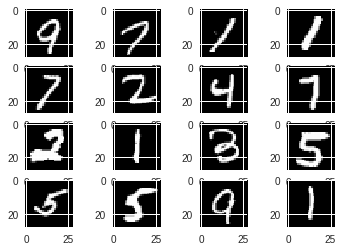

In [0]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = train_data['data'][np.random.randint(0, X_train.shape[0]),:]
    I = I.reshape((28, 28))
    plt.imshow(I, cmap='gray')

In [0]:
X_train = X_train.astype('float')
Xm = np.mean(X_train, axis=0)
Xs = np.std(X_train, axis=0)
X_train=(X_train - Xm) / (Xs + 0.01)

X_test = X_test.astype('float')
X_test=(X_test - Xm) / (Xs + 0.01)

In [0]:
# Подготовка датасета
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train_oh, test_size=0.1, stratify=Y_train)

In [0]:
# Определение слоев сети
# class Dense:
class Dense:
    
    def __init__(self, in_size, out_size, rlambda = 0.0):
        self.W = np.random.normal(scale=1, size=(out_size, in_size)) * np.sqrt(2/in_size)
        self.b = np.zeros(out_size)
        self.rlambda = rlambda

    def forward(self, x):
        self.x = x 
        return np.dot(self.W, x) + self.b
    
    def get_reg_loss(self):
        return 0.5 * self.rlambda * (np.linalg.norm(self.W, ord='fro') ** 2)
    
    def backward(self, dz, lr=0.001):
        self.dW = np.outer(dz, self.x)
        self.db = dz
        self.dx = np.matmul(dz, self.W) 
        
        if(self.rlambda != 0):
            self.dW += self.rlambda * self.W
            
        self.W = self.W - lr * self.dW
        self.b = self.b - lr * self.db
        return self.dx

In [0]:
class ReLU:
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)

    def backward(self, dz, lr=0.1):
        dz[self.x < 0] = 0
        return dz

In [0]:
class Softmax:
    
    def forward(self, x):
        self.x = x
        exps = np.exp(x)
        return exps/np.sum(exps)
    
    def backward(self, dz, lr=0.001):
        sm = self.forward(self.x)
        self.lp = (np.eye(sm.shape[0], sm.shape[0]) - sm).T
        self.lp2 = sm * self.lp
        return np.dot(dz, self.lp2)

In [0]:
class CrossEntropy:
    
    def forward(self, y_true, y_hat):
        self.y_true = y_true
        self.y_hat = y_hat
        return -np.sum( y_true * np.log(y_hat))
    
    def backward(self, dz, lr=0.001):
        return dz * -1. * self.y_true / self.y_hat

In [0]:
# Опеределение самой сети
# class MnistNet:
class MnistNet:
    
    def __init__(self, rlambda=0.0):
        self.d1 = Dense(784, 200, rlambda)
        self.m1 = ReLU()
        self.d2 = Dense(200, 10, rlambda)
        self.m2 = ReLU()
        self.s = Softmax()
    
    def forward(self, x):
        net = self.d1.forward(x)
        net = self.m1.forward(net)
        net = self.d2.forward(net)
        net = self.m2.forward(net)
        net = self.s.forward(net)
        return net
    
    def backward(self, dz, lr):
        dz = self.s.backward(dz, lr)
        dz = self.m2.backward(dz, lr)
        dz = self.d2.backward(dz, lr)
        dz = self.m1.backward(dz, lr)
        dz = self.d1.backward(dz, lr)
        return dz

In [17]:
from tqdm import tqdm_notebook

net = MnistNet(0.0005)

loss = CrossEntropy()
lr = 0.001

L_train = []
L_test = []

for iter in tqdm_notebook(range(100)):
    L_acc = 0.
    sh = list(range(x_train.shape[0])) 
    np.random.shuffle(sh)

    for i in range(x_train.shape[0]):
        x = x_train[sh[i]]
        y = y_train[sh[i]]
        y_h = net.forward(x)
        L = loss.forward(y, y_h) + net.d1.get_reg_loss() + net.d2.get_reg_loss()
        L_acc += L 
        dz = loss.backward(1, lr)
        dz = net.backward(dz, lr)
        
    L_acc /= y_train.shape[0]
    L_train.append(L_acc)
    L_e_acc = 0.
    
    for i in range(x_test.shape[0]):
        x = x_test[i]
        y = y_test[i]
        y_h = net.forward(x)
        L = loss.forward(y, y_h) + net.d1.get_reg_loss() + net.d2.get_reg_loss()
        L_e_acc += L
        
    L_e_acc /= y_test.shape[0]
    L_test.append(L_e_acc)

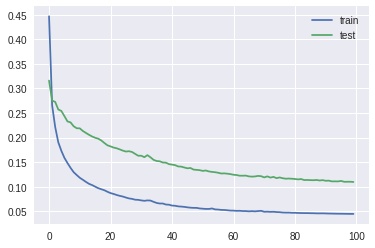

In [18]:
# Здесь необходимо отрисовать графики CrossEntropyLoss для обучающей и валидационной выборок
plt.plot(L_train, label='train')
plt.plot(L_test, label='test')
plt.legend()
plt.show()

In [0]:
# формируем сабмишшен и заливаем его на kaggle
make_submission(X_test, net)